In [1]:
!pip install opendatasets --quiet
!pip install kaggle --quiet

In [2]:
import opendatasets as opd
import os
import zipfile
# Download dataset using Kaggle credentials
dataset_url = "https://www.kaggle.com/datasets/carlolepelaars/camvid"
opd.download(dataset_url)

# Set dataset folder (adjust path if needed)
dataset_folder = "camvid"
print("Dataset directory contents:")
print(os.listdir(dataset_folder))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  sauravsoni941


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid
Dataset directory contents:
['CamVid']


In [4]:
!pip install scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 119.9 MB/s eta 0:00:00


In [5]:
import glob
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from skimage.filters import sobel
from skimage.morphology import disk, binary_dilation



In [42]:
####################################
# 1. CamVid Dataset Loader
####################################
import os
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd

class CamVidDataset(Dataset):
    """
    CamVid dataset loader with RGB mask to class index conversion.
    Expects directory structure:
        camvid/
            train/
            train_labels/
            val/
            val_labels/
            test/
            test_labels/
    """
    def __init__(self, root, split='train', transform=None, image_size=(360, 480), target_transform=None, class_dict_path='camvid/CamVid/class_dict.csv'):
        self.root = root
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        self.image_dir = os.path.join(root, split)
        self.label_dir = os.path.join(root, f"{split}_labels")

        self.image_paths = sorted(glob.glob(os.path.join(self.image_dir, '*.png')))
        self.label_paths = sorted(glob.glob(os.path.join(self.label_dir, '*.png')))
        self.label_resize = transforms.Resize(image_size, interpolation=Image.NEAREST)
        self.image_resize = transforms.Resize(image_size, interpolation=Image.BILINEAR)
        assert len(self.image_paths) == len(self.label_paths), "Mismatch between images and labels."

        # Load class_dict.csv and build color-to-class mapping
        df = pd.read_csv(class_dict_path)
        self.color_to_class = {
            (row['r'], row['g'], row['b']): idx for idx, row in df.iterrows()
        }

    def __len__(self):
        return len(self.image_paths)

    def rgb_to_class(self, mask):
        """Convert an RGB mask (PIL.Image) to a 2D class index mask."""
        mask_np = np.array(mask)
        h, w, _ = mask_np.shape
        class_mask = np.zeros((h, w), dtype=np.uint8)

        for rgb, class_idx in self.color_to_class.items():
            matches = (mask_np == rgb).all(axis=2)
            class_mask[matches] = class_idx

        return class_mask

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = Image.open(self.label_paths[idx]).convert('RGB')

        # Resize both to 360x480
        image = self.image_resize(image)
        label = self.label_resize(label)

        if self.transform:
            image = self.transform(image)

        label = self.rgb_to_class(label)
        label = torch.from_numpy(label).long()

        return image, label




# Define input image transforms
input_transform = transforms.Compose([
    transforms.Resize((360, 480)),  # Or larger if needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def label_transform(label):
    # Resize using nearest neighbor so that labels are not interpolated
    label = label.resize((480, 360), Image.NEAREST)
    label = np.array(label, dtype=np.int64)
    return torch.from_numpy(label)



In [36]:
####################################
# 2. SegNet Model with VGG16 Backbone
####################################
class SegNet(nn.Module):
    def __init__(self, num_classes=32):
        super(SegNet, self).__init__()
        vgg16 = models.vgg16_bn(pretrained=True)

        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)

        # Encoder blocks (from VGG16-BN)
        self.enc1 = nn.Sequential(*vgg16.features[:6])    # 64
        self.enc2 = nn.Sequential(*vgg16.features[7:13])  # 128
        self.enc3 = nn.Sequential(*vgg16.features[14:23]) # 256
        self.enc4 = nn.Sequential(*vgg16.features[24:33]) # 512

        # Decoder blocks (mirror encoder in reverse order)
        self.dec4 = self.decoder_block(512, 256)
        self.dec3 = self.decoder_block(256, 128)
        self.dec2 = self.decoder_block(128, 64)
        self.dec1 = self.decoder_block(64, 64)

        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x1p, ind1 = self.pool(x1)

        x2 = self.enc2(x1p)
        x2p, ind2 = self.pool(x2)

        x3 = self.enc3(x2p)
        x3p, ind3 = self.pool(x3)

        x4 = self.enc4(x3p)
        x4p, ind4 = self.pool(x4)

        # Decoder: unpool then decode (match encoder output shape before unpooling)
        d4 = self.unpool(x4p, ind4, output_size=x4.size())  # 512 channels
        d4 = self.dec4(d4)  # 512 → 256

        d3 = self.unpool(d4, ind3, output_size=x3.size())  # 256 channels
        d3 = self.dec3(d3)  # 256 → 128

        d2 = self.unpool(d3, ind2, output_size=x2.size())  # 128
        d2 = self.dec2(d2)  # 128 → 64

        d1 = self.unpool(d2, ind1, output_size=x1.size())  # 64
        d1 = self.dec1(d1)  # 64 → 64

        out = self.classifier(d1)  # 64 → num_classes
        return out


In [28]:
####################################
# 3. Metric Computations
####################################
def compute_global_accuracy(pred, target):
    """Compute percentage of correctly classified pixels."""
    valid = (target >= 0)
    correct = (pred[valid] == target[valid]).sum()
    total = valid.sum()
    return correct / total if total > 0 else 0

def compute_class_accuracy(pred, target, num_classes):
    """Compute average accuracy over classes."""
    class_acc = []
    for cls in range(num_classes):
        mask = (target == cls)
        if mask.sum() == 0:
            continue
        correct = (pred[mask] == cls).sum().item()
        acc = correct / mask.sum().item()
        class_acc.append(acc)
    return np.mean(class_acc) if class_acc else 0

def compute_mIoU(pred, target, num_classes):
    """Compute mean Intersection over Union (mIoU) over all classes."""
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def compute_boundary_f1(pred, target, tolerance=0):
    """
    Compute Boundary F1 Score (BF):
       This version extracts boundaries using Sobel filter and then dilates
       them by a tolerance radius. Precision and Recall are computed, and then the F1 score.
    """
    # Convert inputs to numpy arrays
    pred = pred.astype(np.uint8)
    target = target.astype(np.uint8)

    # Extract boundaries using the gradient magnitude (Sobel)
    pred_edges = sobel(pred) > 0.05
    target_edges = sobel(target) > 0.05

    # Determine tolerance if not provided: 0.75% of image diagonal
    if tolerance <= 0:
        h, w = pred.shape
        tolerance = int(round(0.0075 * math.hypot(h, w)))
    # Create a disk-shaped structuring element for dilation
    selem = disk(tolerance)

    pred_dilated = binary_dilation(pred_edges, selem)
    target_dilated = binary_dilation(target_edges, selem)

    # Precision: proportion of predicted edge pixels that match target edges
    true_pos = (pred_edges & target_dilated).sum()
    precision = true_pos / (pred_edges.sum() + 1e-6)

    # Recall: proportion of target edge pixels that were detected in prediction
    recall = true_pos / (target_edges.sum() + 1e-6)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return f1

def evaluate_metrics(outputs, targets, num_classes):
    """
    Given model outputs and ground truth targets (as tensors),
    compute global accuracy, class average accuracy, mIoU and BF score.
    Assumes outputs are raw logits.
    """
    # Convert raw logits into predicted class indices
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    targets = targets.cpu().numpy()

    # Assuming batch dimension; compute metrics per image and then average.
    global_accs, class_accs, mious, bfs = [], [], [], []
    for pred, target in zip(preds, targets):
        global_accs.append(compute_global_accuracy(pred, target))
        class_accs.append(compute_class_accuracy(pred, target, num_classes))
        mious.append(compute_mIoU(pred, target, num_classes))
        bfs.append(compute_boundary_f1(pred, target))

    return np.mean(global_accs), np.mean(class_accs), np.mean(mious), np.mean(bfs)




In [43]:
####################################
# 4. Training Setup and DataLoaders
####################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

# Parameters
num_classes = 32
data_root = 'camvid/CamVid/'  # make sure this matches your structure

# Load datasets and dataloaders (assuming CamVidDataset is already defined)
train_dataset = CamVidDataset(root=data_root, split='train',
                              transform=input_transform, target_transform=label_transform)
val_dataset = CamVidDataset(root=data_root, split='val',
                              transform=input_transform, target_transform=label_transform)
test_dataset = CamVidDataset(root=data_root, split='test',
                              transform=input_transform, target_transform=label_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

# ------------------------
# Dataset Size Info
# ------------------------
print("Dataset sizes:")
print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples")
print(f"Test:  {len(test_dataset)} samples")

# ------------------------
# Shape + Visual Inspection
# ------------------------
def visualize_batch(images, labels):
    batch_size = len(images)
    fig, axs = plt.subplots(batch_size, 2, figsize=(8, 4 * batch_size))
    for i in range(batch_size):
        img = images[i].permute(1, 2, 0).numpy()
        mask = labels[i].squeeze().numpy()
        axs[i, 0].imshow(img)
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=num_classes-1)
        axs[i, 1].set_title("Segmentation Mask")
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
print("Sample batch shape:")
print("Images:", images.shape)  # [B, C, H, W]
print("Labels:", labels.shape)  # [B, 1, H, W] or [B, H, W]
# visualize_batch(images, labels)

Training on: cuda
Dataset sizes:
Train: 369 samples
Val:   100 samples
Test:  232 samples
Sample batch shape:
Images: torch.Size([4, 3, 360, 480])
Labels: torch.Size([4, 360, 480])


In [44]:
# Initialize model, loss, optimizer
model = SegNet(num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)  # adjust ignore_index if needed
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
####################################
# 5. Training Loop with Metrics and Visualization
####################################
num_epochs = 50
best_val_global_acc = 0.0

# To store metrics for plotting over epochs.
train_loss_history = []
val_loss_history = []
global_acc_history = []
class_acc_history = []
miou_history = []
bf_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    global_acc_total, class_acc_total, miou_total, bf_total = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            g_acc, c_acc, miou, bf = evaluate_metrics(outputs, masks, num_classes)
            global_acc_total += g_acc
            class_acc_total += c_acc
            miou_total += miou
            bf_total += bf

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    avg_global_acc = global_acc_total / len(val_loader)
    avg_class_acc = class_acc_total / len(val_loader)
    avg_miou = miou_total / len(val_loader)
    avg_bf = bf_total / len(val_loader)

    global_acc_history.append(avg_global_acc)
    class_acc_history.append(avg_class_acc)
    miou_history.append(avg_miou)
    bf_history.append(avg_bf)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
          f"| Global Acc: {avg_global_acc:.4f} | Class Acc: {avg_class_acc:.4f} "
          f"| mIoU: {avg_miou:.4f} | BF: {avg_bf:.4f}")

    # Save the best model based on global accuracy
    if avg_global_acc > best_val_global_acc:
        best_val_global_acc = avg_global_acc
        torch.save(model.state_dict(), 'segnet_camvid_best.pth')
        print("Saved best model!")




Epoch [1/50] Train Loss: 2.3663 | Val Loss: 1.5413 | Global Acc: 0.7837 | Class Acc: 0.2719 | mIoU: 0.1503 | BF: 0.2424
Saved best model!
Epoch [2/50] Train Loss: 1.5396 | Val Loss: 1.3334 | Global Acc: 0.7979 | Class Acc: 0.2945 | mIoU: 0.1819 | BF: 0.2352
Saved best model!
Epoch [3/50] Train Loss: 1.2585 | Val Loss: 1.1339 | Global Acc: 0.8181 | Class Acc: 0.3116 | mIoU: 0.2225 | BF: 0.3065
Saved best model!
Epoch [4/50] Train Loss: 1.0618 | Val Loss: 0.9828 | Global Acc: 0.8284 | Class Acc: 0.3243 | mIoU: 0.2435 | BF: 0.3974
Saved best model!
Epoch [5/50] Train Loss: 0.9132 | Val Loss: 0.8732 | Global Acc: 0.8452 | Class Acc: 0.3543 | mIoU: 0.2813 | BF: 0.4202
Saved best model!
Epoch [6/50] Train Loss: 0.7861 | Val Loss: 0.7875 | Global Acc: 0.8510 | Class Acc: 0.3814 | mIoU: 0.3021 | BF: 0.4455
Saved best model!
Epoch [7/50] Train Loss: 0.6916 | Val Loss: 0.7326 | Global Acc: 0.8549 | Class Acc: 0.3913 | mIoU: 0.3135 | BF: 0.4400
Saved best model!
Epoch [8/50] Train Loss: 0.6206 | 

In [46]:
# ---- Final Results Printing ----
print("\n===== FINAL RESULTS =====")
print(f"Total number of epochs: {num_epochs}")

# Print final training and validation loss
final_train_loss = train_loss_history[-1]
final_val_loss = val_loss_history[-1]
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Val Loss: {final_val_loss:.4f}")

# Print final accuracy metrics on the validation set
final_global_acc = global_acc_history[-1]
final_class_acc = class_acc_history[-1]
final_miou = miou_history[-1]
final_bf = bf_history[-1]

print("\nValidation Metrics (Last Epoch):")
print(f"  Global Accuracy : {final_global_acc:.4f}")
print(f"  Class Average Accuracy : {final_class_acc:.4f}")
print(f"  Mean IoU : {final_miou:.4f}")
print(f"  Boundary F1 Score : {final_bf:.4f}")

# Also print the best global accuracy achieved along with the epoch index
best_epoch = np.argmax(global_acc_history) + 1
best_global_acc = max(global_acc_history)
print("\nBest Validation Global Accuracy:")
print(f"  Best Global Accuracy : {best_global_acc:.4f} at epoch {best_epoch}")

# (Optional) To print the full history of metrics, uncomment the following lines:
# print("\nTraining Loss History:", train_loss_history)
# print("Validation Loss History:", val_loss_history)
# print("Global Accuracy History:", global_acc_history)
# print("Class Accuracy History:", class_acc_history)
# print("Mean IoU History:", miou_history)
# print("Boundary F1 Score History:", bf_history)



===== FINAL RESULTS =====
Total number of epochs: 50
Final Train Loss: 0.0671
Final Val Loss: 0.4220

Validation Metrics (Last Epoch):
  Global Accuracy : 0.9053
  Class Average Accuracy : 0.6338
  Mean IoU : 0.4261
  Boundary F1 Score : 0.6390

Best Validation Global Accuracy:
  Best Global Accuracy : 0.9088 at epoch 42


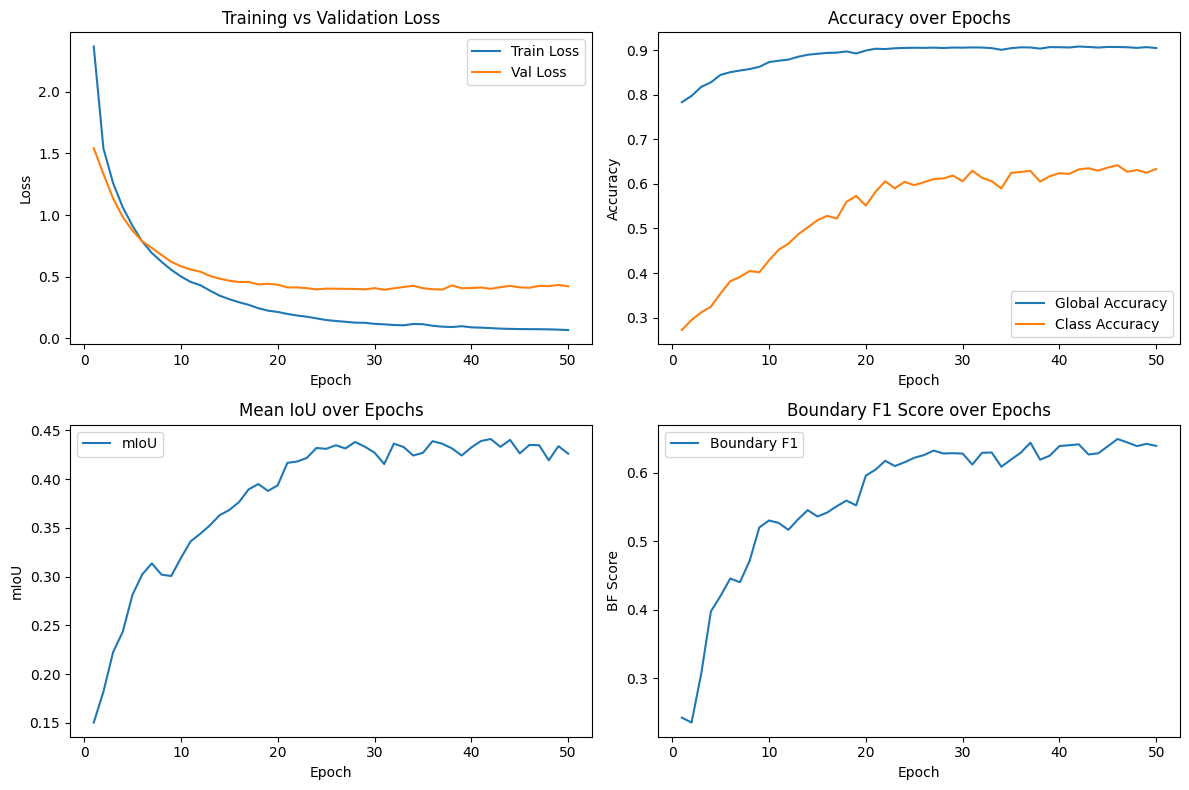

In [47]:
####################################
# 6. Plotting Learning Curves and Metrics
####################################
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, global_acc_history, label='Global Accuracy')
plt.plot(epochs, class_acc_history, label='Class Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, miou_history, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Mean IoU over Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, bf_history, label='Boundary F1')
plt.xlabel("Epoch")
plt.ylabel("BF Score")
plt.title("Boundary F1 Score over Epochs")
plt.legend()
plt.tight_layout()
plt.show()



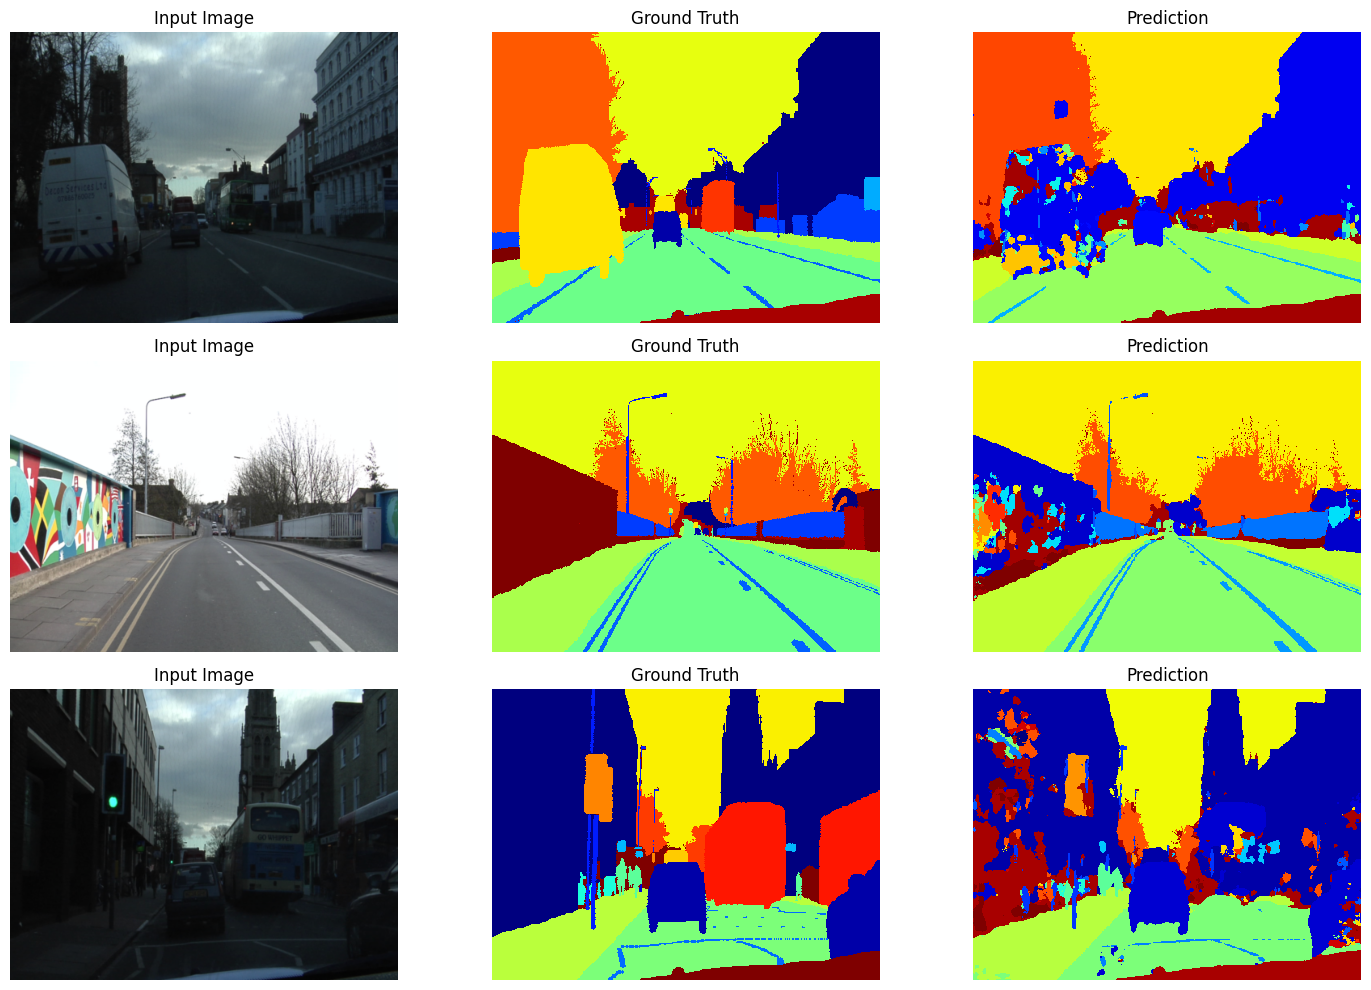

Training complete, best model saved to segnet_camvid_best.pth


In [48]:
####################################
# 7. Visualize Predictions on Test Data
####################################
def visualize_predictions(model, dataloader, num_samples=3):
    model.eval()
    samples_shown = 0
    plt.figure(figsize=(15, 10))
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()

            for i in range(images.shape[0]):
                if samples_shown >= num_samples:
                    break
                # Denormalize image for visualization
                img = images[i].transpose(1, 2, 0)
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                plt.subplot(num_samples, 3, samples_shown * 3 + 1)
                plt.imshow(img)
                plt.title("Input Image")
                plt.axis('off')

                plt.subplot(num_samples, 3, samples_shown * 3 + 2)
                plt.imshow(masks[i], cmap='jet', interpolation='nearest')
                plt.title("Ground Truth")
                plt.axis('off')

                plt.subplot(num_samples, 3, samples_shown * 3 + 3)
                plt.imshow(preds[i], cmap='jet', interpolation='nearest')
                plt.title("Prediction")
                plt.axis('off')

                samples_shown += 1
            if samples_shown >= num_samples:
                break
    plt.tight_layout()
    plt.show()

# Visualize a few predictions from the test set
visualize_predictions(model, test_loader, num_samples=3)

print("Training complete, best model saved to segnet_camvid_best.pth")

In [65]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def predict_single_image(model, image_path, class_colors, device='cuda'):
    """
    Predicts and visualizes the segmentation of a single image using the trained model.
    
    Args:
        model: Trained segmentation model
        image_path: Path to the input image
        class_colors: List of RGB tuples (len = num_classes)
        device: 'cuda' or 'cpu'
    """
    model.eval()
    model.to(device)

    # Preprocessing
    input_size = (360, 480)
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    original_image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(original_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    # Convert predicted class indices to RGB
    color_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in enumerate(class_colors):
        color_mask[pred_mask == class_idx] = color
    color_mask = Image.fromarray(color_mask)

    # Unnormalize for visualization
    unnormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    unnorm_img = unnormalize(input_tensor.squeeze()).cpu().numpy()
    unnorm_img = np.clip(unnorm_img.transpose(1, 2, 0), 0, 1)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(unnorm_img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title("Predicted Segmentation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


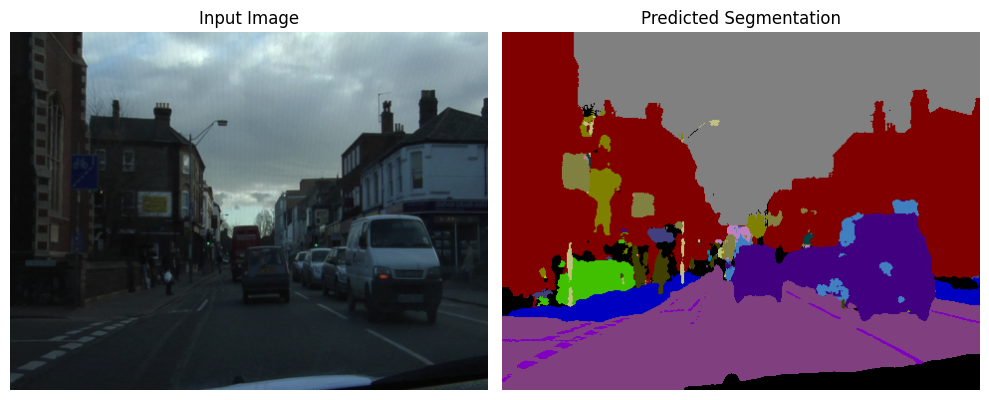

In [68]:
# Load your model
model = SegNet(num_classes=32)  # Make sure num_classes is right
model.load_state_dict(torch.load('segnet_camvid_best.pth'))  # your trained model
model.to('cuda')

# Load class colors from CSV (already loaded earlier probably)
# class_colors = [(r, g, b), ...] from your CSV
df = pd.read_csv('camvid/CamVid/class_dict.csv')
color_to_class = {
    (row['r'], row['g'], row['b']): idx for idx, row in df.iterrows()
}

# Predict
predict_single_image(model, "camvid/CamVid/test/0001TP_007680.png", color_to_class)
# predicted_mask.save('mask_output.png')
# predicted_mask.show()
